# Trabajo Práctico 1: Propiedades en Venta - KNN (Regresión)

## Grupo 11 - "Los Outliers"
- Castillo, Carlos
- Destefanis, Juan Pablo
- Gómez, Celeste

# Setup Inicial

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_theme()
sns.set_palette("colorblind")

Trabajamos con el dataset ya modificado luego de las operaciones de preprocesamiento que se hicieron para el checkpoint 1.

In [4]:
df = pd.read_csv("propiedades.csv", index_col=0)

# Transformación de Datos

In [5]:
X = df.select_dtypes(include="number").drop(["latitud", "longitud", "precio_m2", "property_price"], axis="columns")
y = df["property_price"]

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=137)

Para modelos que utilizan alguna métrica de distancia al realizar comparaciones entre samples, como es el caso de KNN al determinar cuáles son los vecinos más cercanos a cada punto, es conveniente escalar los valores numéricos de las features para poder hacer una comparación más directa entre los mismos, ya que las diferencias entre las unidades de medida en las que están originalmente estos valores puede alterar la importancia de un valor numérico por sobre el otro. En este caso, todas las columnas utilizadas para el modelo de regresión son numéricas, así que las transformamos todas.

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ct = ColumnTransformer([
    ("scaling", StandardScaler(), X_train.columns)
], remainder="passthrough")

X_train_trans = ct.fit_transform(X_train)

# Entrenamiento

Utilizamos HalvingGridSearch para optimizar el proceso de Grid Search.

En este caso probamos con diferentes valores de los hyperparámetros `n_neighbors`, que determina la cantidad de vecinos con los que se compara cada punto, y `metric`, que indica el tipo de distancia utilizado para determinar la cercanía de un punto con sus vecinos.

En el caso de los rangos de la cantidad de vecinos probados, es siguió el rango recomendado en [esta publicación](https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb#:~:text=The%20optimal%20K%20value%20usually,be%20aware%20of%20the%20outliers).

Se decidió utilizar la métrica Root Mean Squared Error.

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsRegressor

sqrt_samples = np.sqrt(len(X_train_trans))

params =  {
    "n_neighbors": np.arange(sqrt_samples - 20, sqrt_samples + 20, dtype="int"),
    "metric": ["minkowski", "euclidean", "manhattan"],
}


reg = HalvingGridSearchCV(estimator=KNeighborsRegressor(),
                          param_grid=params,
                          cv=5,
                          scoring="neg_root_mean_squared_error",
                          verbose=2)

Para entrenar al modelo utilizamos el método fit con el set de entrenamiento ya transformado:

```python
reg.fit(X_train_trans, y_train)
```

Sin embargo, luego de haber ejecutado este método con anterioridad, ya contamos con el modelo más óptimo encontrado, que ha sido exportado en un archivo de joblib, lo que nos permite simplemente cargar el archivo y no tener que volver a entrenar todos los modelos con todos los parámetros que probamos.

Tras el entreno, el modelo con mejor rendimiento resultó ser el que utiliza 238 vecinos para las comparaciones y la distancia euclideana.

In [1]:
from joblib import load

knn = load("knn.joblib")
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 238,
 'p': 2,
 'weights': 'uniform'}

# Evaluación

Ahora utilizamos el modelo con dataset de test para evaluar el rendimiento del mismo ante datos que nunca ha visto. Para esto tenemos que aplicarle las mismas transformaciones al conjunto de test que utilizamos con el conjunto de entrenamiento.

In [8]:
X_test_trans = ct.fit_transform(X_test)

In [9]:
y_pred = knn.predict(X_test_trans)

Podemos visualizar los valores predichos contra los valores reales para darnos una idea visual de la distribución de los resultados de nuestro modelo. Para esto vamos a utilizar un gráfico de disperción y vamos a graficar la recta de predicción perfecta como referencia.

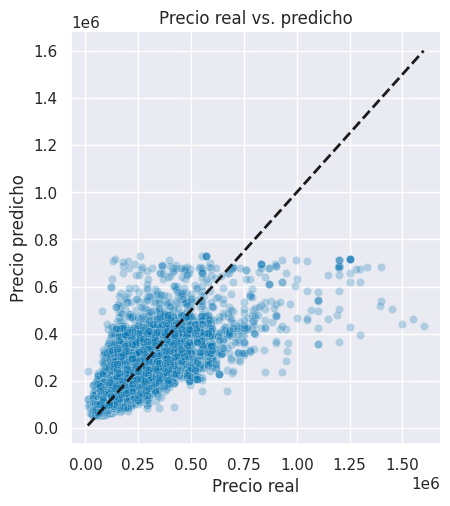

In [39]:
sns.relplot(x=y_test, y=y_pred, kind="scatter", alpha=0.25)

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "k--", lw=2)

plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.title("Precio real vs. predicho")

plt.show()

Otra forma de visualizar la misma información es graficando la distribución de los residuos, es decir, las diferencias entre los valores esperados y obtenidos.

[Text(0.5, 1.0, 'Distribución de residuos')]

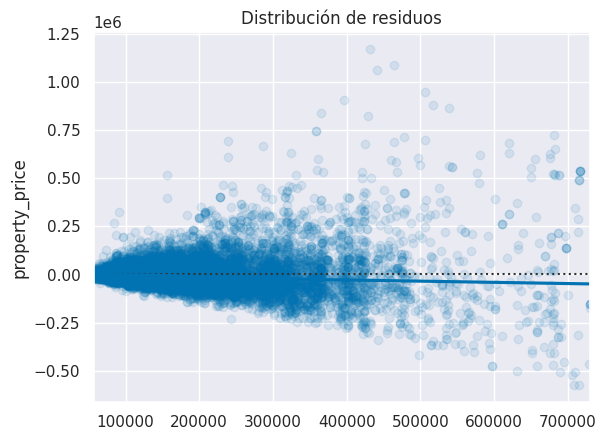

In [37]:
sns.residplot(x=y_pred, y=y_test - y_pred, lowess=True, scatter_kws={"alpha": 0.1}).set(title="Distribución de residuos")

A partir del primer gráfico podemos notar que parece ser que los precios predichos estan acotados o limitados hasta cierto punto, mientras que el rango de precios reales es mucho más extenso. El segundo gráfico pareciera sugerir que a medida incrementa el precio real de una propiedad, la incerteza del modelo también aumenta.

Podemos comprobar esto observando los máximos de cada conjunto.

In [25]:
int(y_pred.max()), int(y_test.max())

(729392, 1600000)

Efectivamente los precios máximos que predice el modelo no cubren el mismo rango que los precios reales en el extremo superior. Esto se puede deber a que los precios que vió el modelo cuando se entrenó no incluían muchas muestras con precios tan altos como los reales, por lo que el modelo no aprendió que hay precios que exeden significativamente el umbral que actualmente tiene establecido. A pesar de haber utilizado técnicas de scaling para evitar malinterpretaciones de las unidades de medida para evitar comportamientos como este.

Finalmente podemos hacer un análisis de las métricas del modelo para comparar su rendimiento con mayor precisión.

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse:.4f}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

Mean Absolute Error (MAE): 47554.2621
Mean Squared Error (MSE): 6857535904.1300
Root Mean Squared Error (RMSE): 82810.2403


También analizamos el valor de la métrica $R^2$, que a diferencia de las métricas anteriores que están relacionadas con los errores que comete el modelo en las predicciones, esta métrica explica los grados de relaciones entre las variables de entrada y la variable de salida.

In [34]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.6113976817952658

Este valor nos quiere decir que aproximadamente el 60% de la varianza de la variable de salida puede ser explicada por la variables independientes.